In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pennylane as qml
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [2]:
with open('i2parallel-tfim2-100.pickle', 'rb') as f:
    tfim2data_list_100 = pickle.load(f)
    
with open('i2parallel-tfim2-200.pickle', 'rb') as f:
    tfim2data_list_200 = pickle.load(f)    
    
with open('i2parallel-tfim2-400.pickle', 'rb') as f:
    tfim2data_list_400 = pickle.load(f)    

In [3]:
w_list=[tfim2data_list_200[x][0] for x in range(1000)]

### TFIM2

In [4]:
np.random.seed(1)
(a1,a2,a3,a4,J1,J2,J3) = [np.round(np.random.uniform(),5) for x in range(7)]

coeff=(a1,a2,a3,a4,J1,J2,J3)

N_qubits=4
a_coeff=[a1,a2,a3,a4]

J_coeff=[J1,J2,J3]
print(a_coeff)
print(J_coeff)


Ham=0
for i in range(N_qubits):
    Ham+=qml.PauliX(i)*a_coeff[i]

for i in range(N_qubits-1):
    Ham+= qml.PauliZ(i)@qml.PauliZ(i+1) * J_coeff[i]

eigenValues, eigenVectors = np.linalg.eig(qml.matrix(Ham))
idx = eigenValues.argsort()[::1]   
eigenValues = eigenValues[idx].real
eigenVectors = eigenVectors[:,idx]
eigenValues
print(eigenValues)

[0.41702, 0.72032, 0.00011, 0.30233]
[0.14676, 0.09234, 0.18626]
[-1.50807204 -1.50788644 -0.79787145 -0.79768585 -0.69656335 -0.69637775
 -0.01382284 -0.01363724  0.01363724  0.01382284  0.69637775  0.69656335
  0.79768585  0.79787145  1.50788644  1.50807204]


In [5]:
o_vectors = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]

# SSVQE
dev = qml.device("lightning.qubit", wires=N_qubits)
@qml.qnode(dev,diff_method="adjoint")
def single_cost(params_in,vector):
    
    qml.BasisState(np.array(vector), wires=range(N_qubits))
    
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.expval(Ham)

@qml.qnode(dev,diff_method="adjoint")
def v1(params_in):
    
    qml.BasisState(np.array([0, 0, 0, 0]), wires=range(N_qubits))
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.expval(Ham)

@qml.qnode(dev,diff_method="adjoint")
def v2(params_in):
    
    qml.BasisState(np.array([0, 0, 0, 1]), wires=range(N_qubits))
    
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.expval(Ham)
@qml.qnode(dev,diff_method="adjoint")
def v3(params_in):
    
    qml.BasisState(np.array([0, 0, 1, 0]), wires=range(N_qubits))
    
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.expval(Ham)


k_number=3

def total_cost_in(params,weight):
    cost = 0
    for i in range(k_number):
        cost+=weight[i]*single_cost(params,o_vectors[i])
    return cost 

def tfim2_Enw_ans(weight):
    ans=0
    for i in range(k_number):
        ans+=weight[i]*eigenValues[i]
    return ans

In [6]:
tfim2_Enw=np.array([tfim2_Enw_ans(x) for x in w_list])

In [7]:
tfim2_100_Fparams=[tfim2data_list_100[x][1][-1] for x in range(1000)]
tfim2_200_Fparams=[tfim2data_list_200[x][1][-1] for x in range(1000)]
tfim2_400_Fparams=[tfim2data_list_400[x][1][-1] for x in range(1000)]

In [8]:
Ew_100=[]
Ew_200=[]
Ew_400=[]
for i in range(1000):    
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    Wei=w_list[i]
    VQE_ans_100=total_cost_in(para_in_100,Wei)
    VQE_ans_200=total_cost_in(para_in_200,Wei)
    VQE_ans_400=total_cost_in(para_in_400,Wei)
    Ew_100.append(VQE_ans_100)
    Ew_200.append(VQE_ans_200)
    Ew_400.append(VQE_ans_400)    

In [9]:
delta_Ew100= np.array(Ew_100)-tfim2_Enw
delta_Ew200= np.array(Ew_200)-tfim2_Enw
delta_Ew400= np.array(Ew_400)-tfim2_Enw

In [10]:
logdelta_Ew100= np.log10(delta_Ew100)
logdelta_Ew200= np.log10(delta_Ew200)
logdelta_Ew400= np.log10(delta_Ew400)

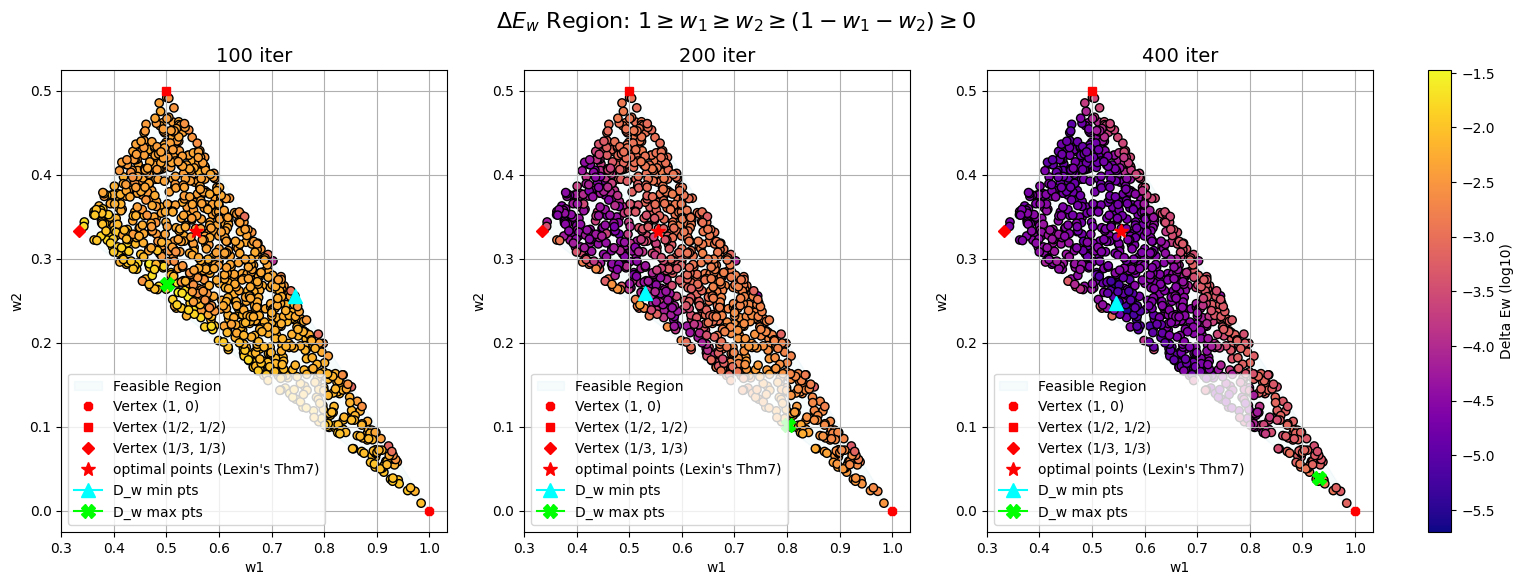

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

positions = np.array(w_list)

# Vertices and optimal points (replace with your actual values)
v1_x, v1_y = 1, 0
v2_x, v2_y = 0.5, 0.5
v3_x, v3_y = 1 / 3, 1 / 3
vox=5/9
voy=3/9

# Generate values for x (from 0 to 1)
x_vals = np.linspace(0, 1, 500)

# Calculate y values satisfying the constraints
y_vals_upper = np.minimum(x_vals, 1 - x_vals)
y_vals_lower = (1 - x_vals) / 2

# Get the global min and max for delta_Ew values
all_delta_Ew = np.concatenate([logdelta_Ew100, logdelta_Ew200, logdelta_Ew400])
norm = mcolors.Normalize(vmin=np.min(all_delta_Ew), vmax=np.max(all_delta_Ew))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta E_w$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_en, subtitle in zip(axes, [logdelta_Ew100, logdelta_Ew200, logdelta_Ew400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_en)][0]
    wminy = w_list[np.argmin(delta_en)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_w min pts')

    wmaxx = w_list[np.argmax(delta_en)][0]
    wmaxy = w_list[np.argmax(delta_en)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_w max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_en, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Ew (log10)')

plt.show()

### E1

In [12]:
E1_100=[]
E1_200=[]
E1_400=[]
for i in range(1000):    
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    VQE_ans_100=v1(para_in_100)
    VQE_ans_200=v1(para_in_200)
    VQE_ans_400=v1(para_in_400)
    E1_100.append(VQE_ans_100)
    E1_200.append(VQE_ans_200)
    E1_400.append(VQE_ans_400) 

In [13]:
delta_E1100= np.array(E1_100)-eigenValues[0].real
delta_E1200= np.array(E1_200)-eigenValues[0].real
delta_E1400= np.array(E1_400)-eigenValues[0].real

In [14]:
logdelta_E1100= np.log10(abs(delta_E1100))
logdelta_E1200= np.log10(abs(delta_E1200))
logdelta_E1400= np.log10(abs(delta_E1400))

In [15]:
max(logdelta_E1400)

-3.7521421973850053

In [16]:
max(logdelta_E1100)

-0.37484797815690873

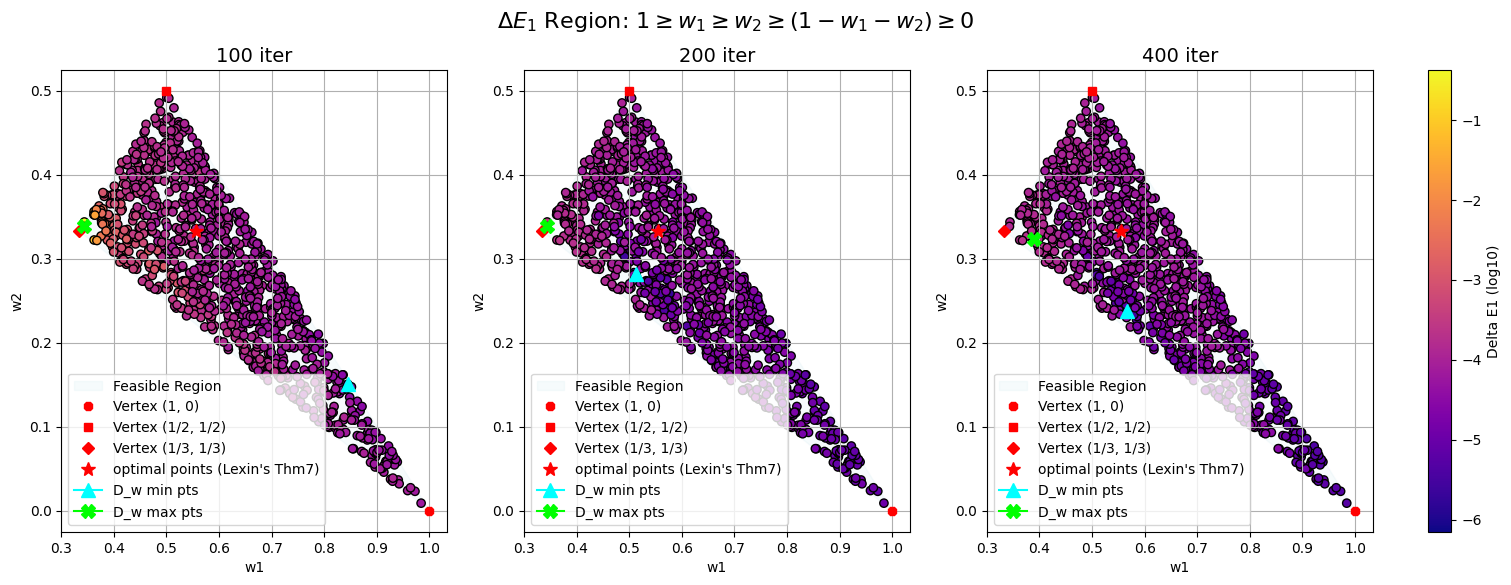

In [17]:
positions = np.array(w_list)

# Vertices and optimal points (replace with your actual values)
v1_x, v1_y = 1, 0
v2_x, v2_y = 0.5, 0.5
v3_x, v3_y = 1 / 3, 1 / 3
vox=5/9
voy=3/9

# Generate values for x (from 0 to 1)
x_vals = np.linspace(0, 1, 500)

# Calculate y values satisfying the constraints
y_vals_upper = np.minimum(x_vals, 1 - x_vals)
y_vals_lower = (1 - x_vals) / 2

# Get the global min and max for delta_Ew values
all_delta_E1 = np.concatenate([logdelta_E1100, logdelta_E1200, logdelta_E1400])
norm = mcolors.Normalize(vmin=np.min(all_delta_E1), vmax=np.max(all_delta_E1))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta E_1$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_e1, subtitle in zip(axes, [logdelta_E1100, logdelta_E1200, logdelta_E1400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_e1)][0]
    wminy = w_list[np.argmin(delta_e1)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_w min pts')

    wmaxx = w_list[np.argmax(delta_e1)][0]
    wmaxy = w_list[np.argmax(delta_e1)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_w max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_e1, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta E1 (log10)')

plt.show()

### E2

In [18]:
E2_100=[]
E2_200=[]
E2_400=[]
for i in range(1000):    
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    VQE_ans_100=v2(para_in_100)
    VQE_ans_200=v2(para_in_200)
    VQE_ans_400=v2(para_in_400)
    E2_100.append(VQE_ans_100)
    E2_200.append(VQE_ans_200)
    E2_400.append(VQE_ans_400) 

In [19]:
delta_E2100= np.array(E2_100)-eigenValues[1].real
delta_E2200= np.array(E2_200)-eigenValues[1].real
delta_E2400= np.array(E2_400)-eigenValues[1].real

In [20]:
logdelta_E2100= np.log10(abs(delta_E2100))
logdelta_E2200= np.log10(abs(delta_E2200))
logdelta_E2400= np.log10(abs(delta_E2400))

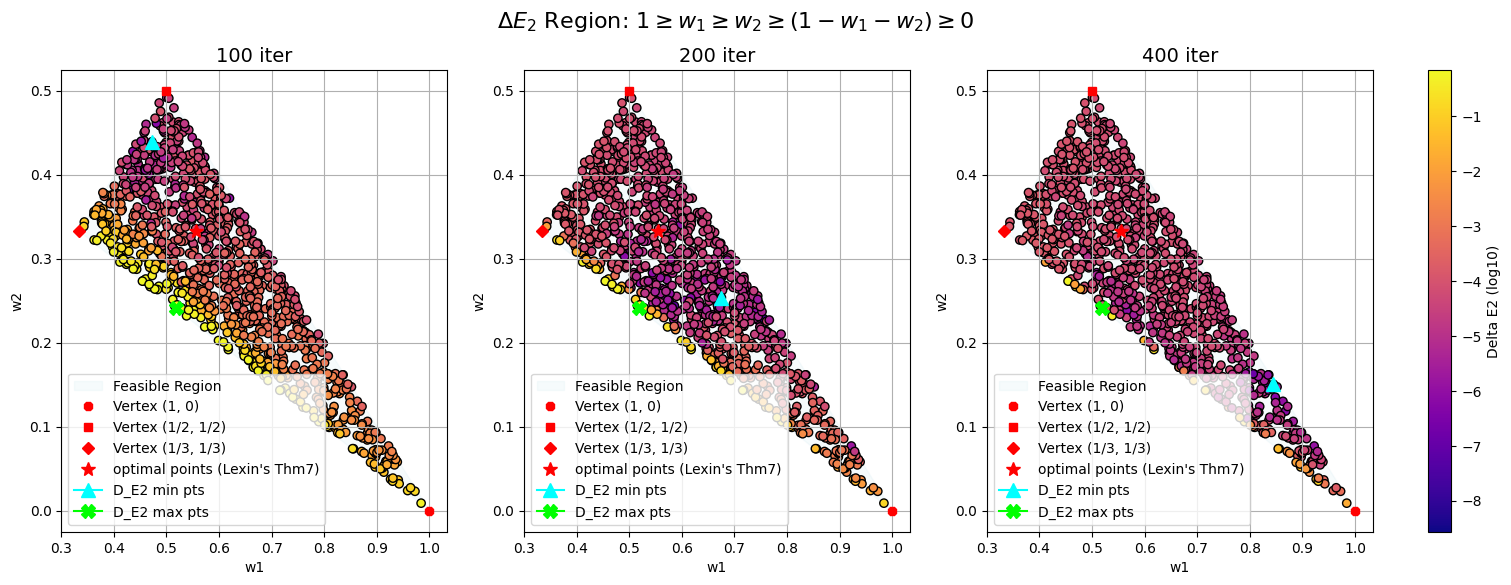

In [22]:
# Get the global min and max for delta_Ew values
all_delta_E2 = np.concatenate([logdelta_E2100, logdelta_E2200, logdelta_E2400])
norm = mcolors.Normalize(vmin=np.min(all_delta_E2), vmax=np.max(all_delta_E2))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta E_2$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_e2, subtitle in zip(axes, [logdelta_E2100, logdelta_E2200, logdelta_E2400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_e2)][0]
    wminy = w_list[np.argmin(delta_e2)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_E2 min pts')

    wmaxx = w_list[np.argmax(delta_e2)][0]
    wmaxy = w_list[np.argmax(delta_e2)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_E2 max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_e2, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta E2 (log10)')

plt.show()

### E3

In [23]:
E3_100=[]
E3_200=[]
E3_400=[]
for i in range(1000):    
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    VQE_ans_100=v3(para_in_100)
    VQE_ans_200=v3(para_in_200)
    VQE_ans_400=v3(para_in_400)
    E3_100.append(VQE_ans_100)
    E3_200.append(VQE_ans_200)
    E3_400.append(VQE_ans_400) 

In [24]:
delta_E3100= np.array(E3_100)-eigenValues[2].real
delta_E3200= np.array(E3_200)-eigenValues[2].real
delta_E3400= np.array(E3_400)-eigenValues[2].real

In [25]:
logdelta_E3100= np.log10(abs(delta_E3100))
logdelta_E3200= np.log10(abs(delta_E3200))
logdelta_E3400= np.log10(abs(delta_E3400))

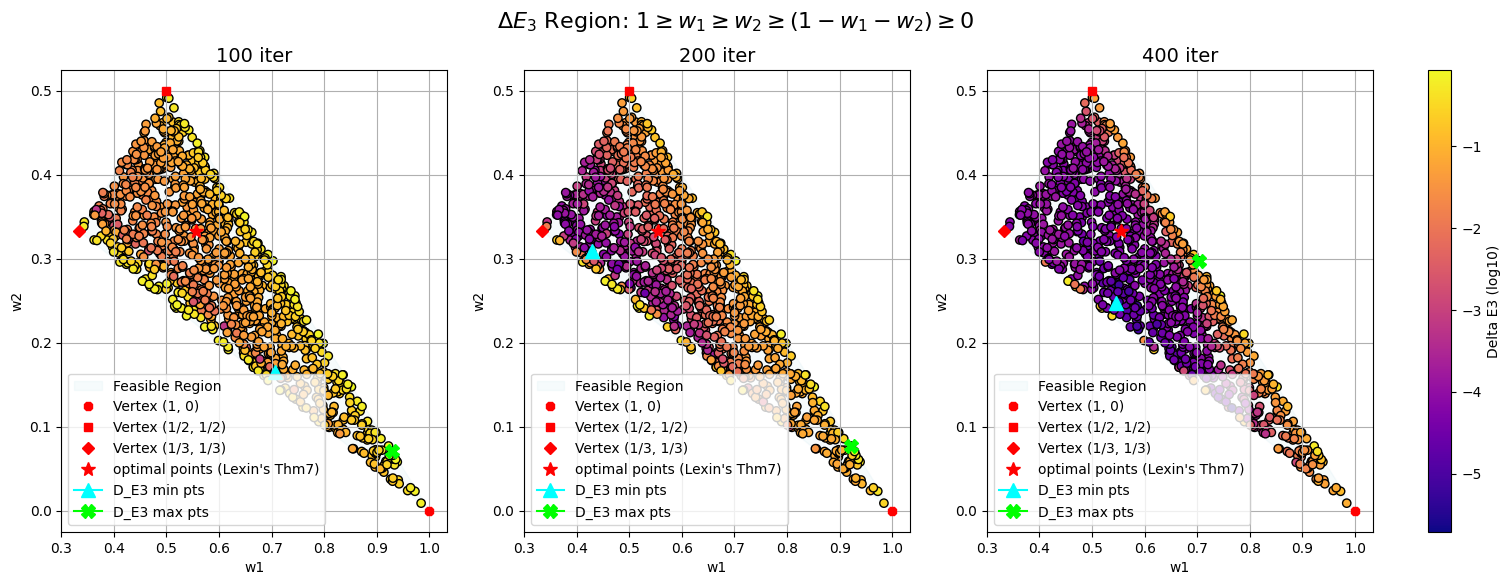

In [61]:
# Get the global min and max for delta_Ew values
all_delta_E3 = np.concatenate([logdelta_E3100, logdelta_E3200, logdelta_E3400])
norm = mcolors.Normalize(vmin=np.min(all_delta_E3), vmax=np.max(all_delta_E3))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta E_3$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_e3, subtitle in zip(axes, [logdelta_E3100, logdelta_E3200, logdelta_E3400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_e3)][0]
    wminy = w_list[np.argmin(delta_e3)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_E3 min pts')

    wmaxx = w_list[np.argmax(delta_e3)][0]
    wmaxy = w_list[np.argmax(delta_e3)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_E3 max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_e3, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta E3 (log10)')

plt.show()

### Eall

In [36]:
delta_Eall_100=abs(delta_E1100)+abs(delta_E2100)+abs(delta_E3100)
delta_Eall_200=abs(delta_E1200)+abs(delta_E2200)+abs(delta_E3200)
delta_Eall_400=abs(delta_E1400)+abs(delta_E2400)+abs(delta_E3400)

In [43]:
delta_Eall_100=np.log10(delta_Eall_100)
delta_Eall_200=np.log10(delta_Eall_200)
delta_Eall_400=np.log10(delta_Eall_400)

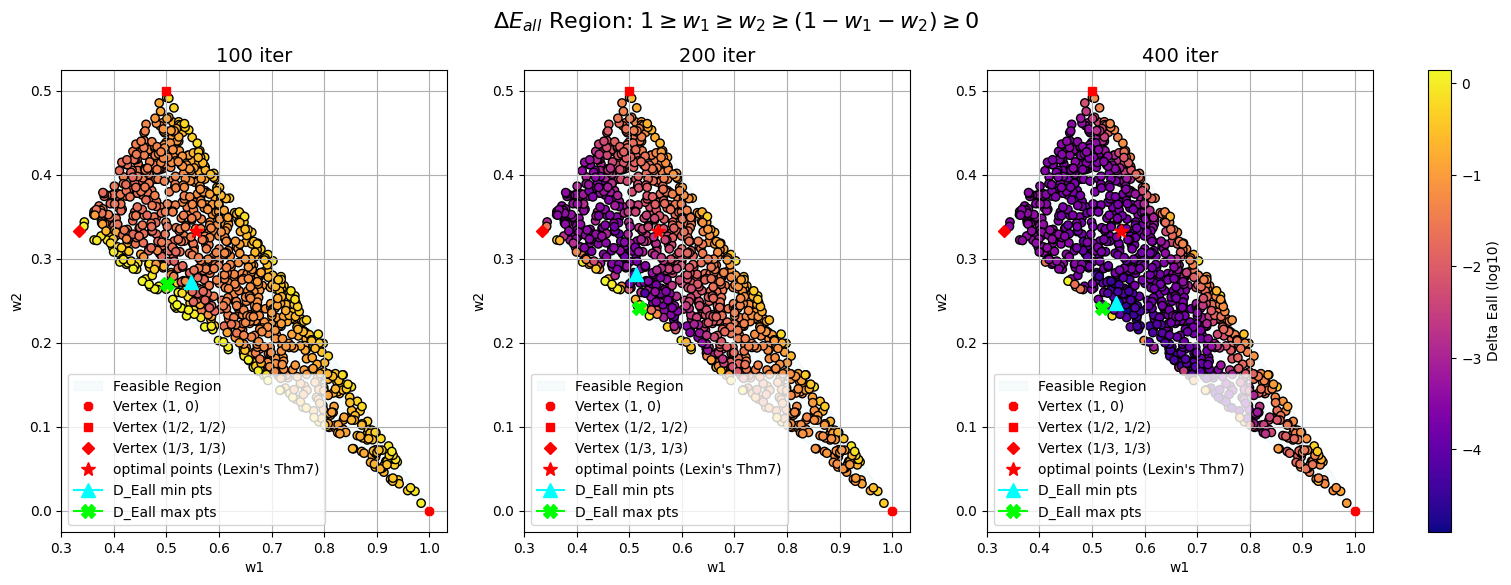

In [45]:
# Get the global min and max for delta_Ew values
all_delta_Eall = np.concatenate([delta_Eall_100,delta_Eall_200,delta_Eall_400])
norm = mcolors.Normalize(vmin=np.min(all_delta_Eall), vmax=np.max(all_delta_Eall))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta E_{all}$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_eall, subtitle in zip(axes, [delta_Eall_100,delta_Eall_200,delta_Eall_400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_eall)][0]
    wminy = w_list[np.argmin(delta_eall)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_Eall min pts')

    wmaxx = w_list[np.argmax(delta_eall)][0]
    wmaxy = w_list[np.argmax(delta_eall)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_Eall max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_eall, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Eall (log10)')

plt.show()

### State

In [27]:
dev = qml.device("lightning.qubit", wires=N_qubits)
@qml.qnode(dev)
def v1_state(params_in):
    
    qml.BasisState(np.array([0, 0, 0, 0]), wires=range(N_qubits))
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.state()

@qml.qnode(dev)
def v2_state(params_in):
    
    qml.BasisState(np.array([0, 0, 0, 1]), wires=range(N_qubits))
    
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.state()
@qml.qnode(dev)
def v3_state(params_in):
    
    qml.BasisState(np.array([0, 0, 1, 0]), wires=range(N_qubits))
    
    qml.StronglyEntanglingLayers(weights=params_in, wires=range(N_qubits))
        
    return qml.state()

In [28]:
# FD https://docs.pennylane.ai/en/stable/code/api/pennylane.math.fidelity_statevector.html

delta_psi1_100=[]
delta_psi1_200=[]
delta_psi1_400=[]
for i in range(len(w_list)):
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    rho_psi100=v1_state(para_in_100)
    rho_psi200=v1_state(para_in_200)
    rho_psi400=v1_state(para_in_400)    
    delta_psi1_100.append(1-qml.math.fidelity_statevector(eigenVectors[:,0],rho_psi100))
    delta_psi1_200.append(1-qml.math.fidelity_statevector(eigenVectors[:,0],rho_psi200))
    delta_psi1_400.append(1-qml.math.fidelity_statevector(eigenVectors[:,0],rho_psi400))

In [29]:
delta_psi2_100=[]
delta_psi2_200=[]
delta_psi2_400=[]
for i in range(len(w_list)):
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    rho_psi100=v2_state(para_in_100)
    rho_psi200=v2_state(para_in_200)
    rho_psi400=v2_state(para_in_400)    
    delta_psi2_100.append(1-qml.math.fidelity_statevector(eigenVectors[:,1],rho_psi100))
    delta_psi2_200.append(1-qml.math.fidelity_statevector(eigenVectors[:,1],rho_psi200))
    delta_psi2_400.append(1-qml.math.fidelity_statevector(eigenVectors[:,1],rho_psi400))

In [30]:
delta_psi3_100=[]
delta_psi3_200=[]
delta_psi3_400=[]
for i in range(len(w_list)):
    para_in_100=tfim2_100_Fparams[i]
    para_in_200=tfim2_200_Fparams[i]
    para_in_400=tfim2_400_Fparams[i]
    rho_psi100=v3_state(para_in_100)
    rho_psi200=v3_state(para_in_200)
    rho_psi400=v3_state(para_in_400)    
    delta_psi3_100.append(1-qml.math.fidelity_statevector(eigenVectors[:,2],rho_psi100))
    delta_psi3_200.append(1-qml.math.fidelity_statevector(eigenVectors[:,2],rho_psi200))
    delta_psi3_400.append(1-qml.math.fidelity_statevector(eigenVectors[:,2],rho_psi400))

In [46]:
logdelta_psi1100= np.log10(delta_psi1_100)
logdelta_psi1200= np.log10(delta_psi1_200)
logdelta_psi1400= np.log10(delta_psi1_400)

logdelta_psi2100= np.log10(delta_psi2_100)
logdelta_psi2200= np.log10(delta_psi2_200)
logdelta_psi2400= np.log10(delta_psi2_400)

logdelta_psi3100= np.log10(delta_psi3_100)
logdelta_psi3200= np.log10(delta_psi3_200)
logdelta_psi3400= np.log10(delta_psi3_400)

### $\Psi_1$

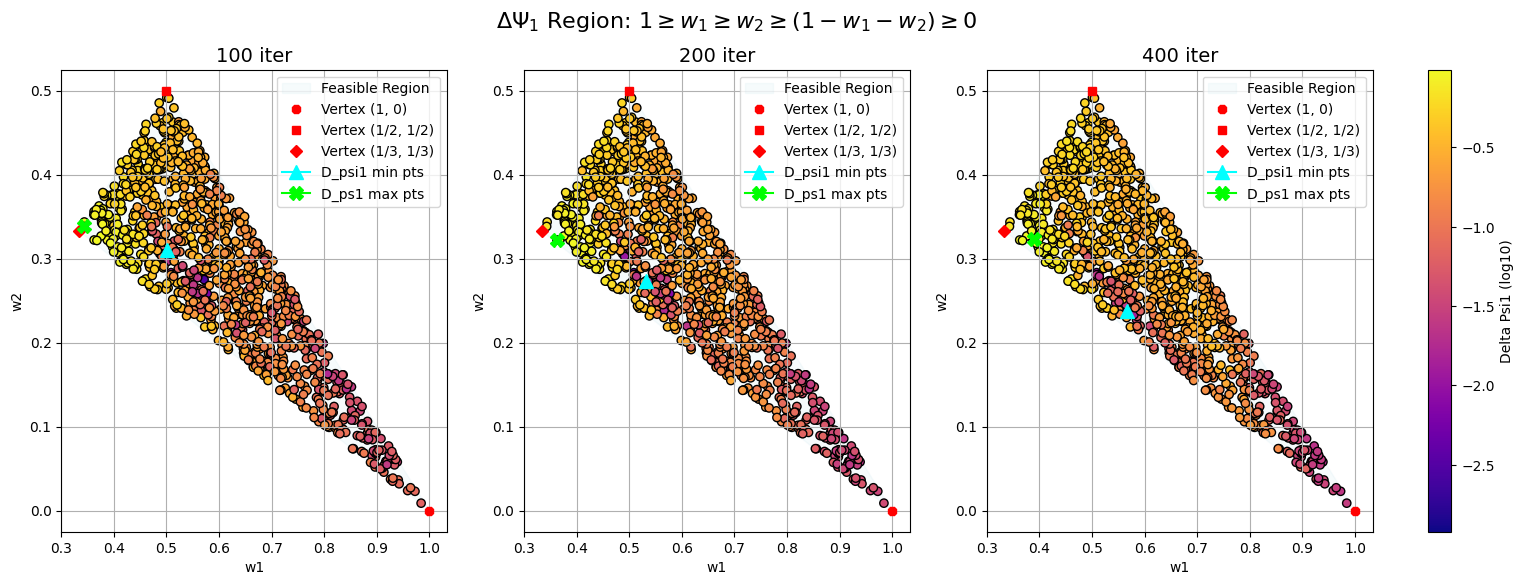

In [48]:
all_delta_Epsi1 = np.concatenate([logdelta_psi1100,logdelta_psi1200,logdelta_psi1400])
norm = mcolors.Normalize(vmin=np.min(all_delta_Epsi1), vmax=np.max(all_delta_Epsi1))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta \Psi_1$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_psi1, subtitle in zip(axes, [logdelta_psi1100,logdelta_psi1200,logdelta_psi1400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    #ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_psi1)][0]
    wminy = w_list[np.argmin(delta_psi1)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_psi1 min pts')

    wmaxx = w_list[np.argmax(delta_psi1)][0]
    wmaxy = w_list[np.argmax(delta_psi1)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_ps1 max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_psi1, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Psi1 (log10)')

plt.show()

### $\Psi_2$

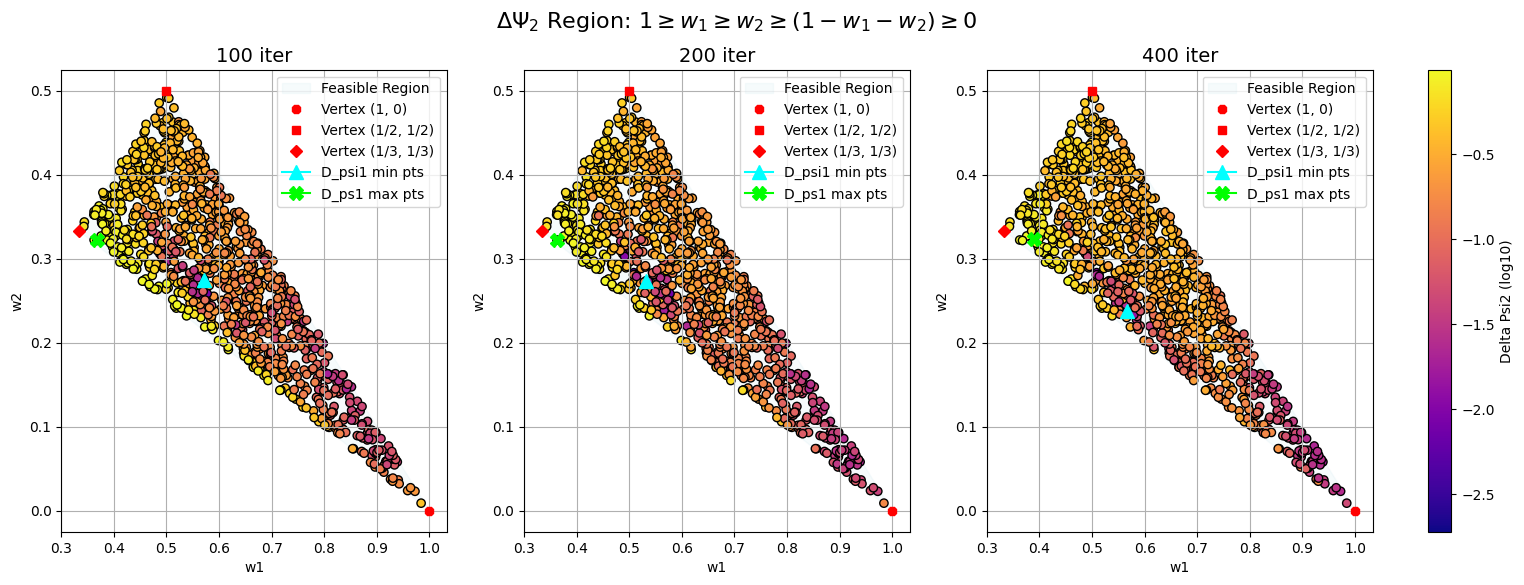

In [62]:
all_delta_Epsi2 = np.concatenate([logdelta_psi2100,logdelta_psi2200,logdelta_psi2400])
norm = mcolors.Normalize(vmin=np.min(all_delta_Epsi2), vmax=np.max(all_delta_Epsi2))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta \Psi_2$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_psi2, subtitle in zip(axes, [logdelta_psi2100,logdelta_psi2200,logdelta_psi2400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    #ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_psi2)][0]
    wminy = w_list[np.argmin(delta_psi2)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_psi1 min pts')

    wmaxx = w_list[np.argmax(delta_psi2)][0]
    wmaxy = w_list[np.argmax(delta_psi2)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_ps1 max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_psi2, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Psi2 (log10)')

plt.show()

### $\Psi_3$

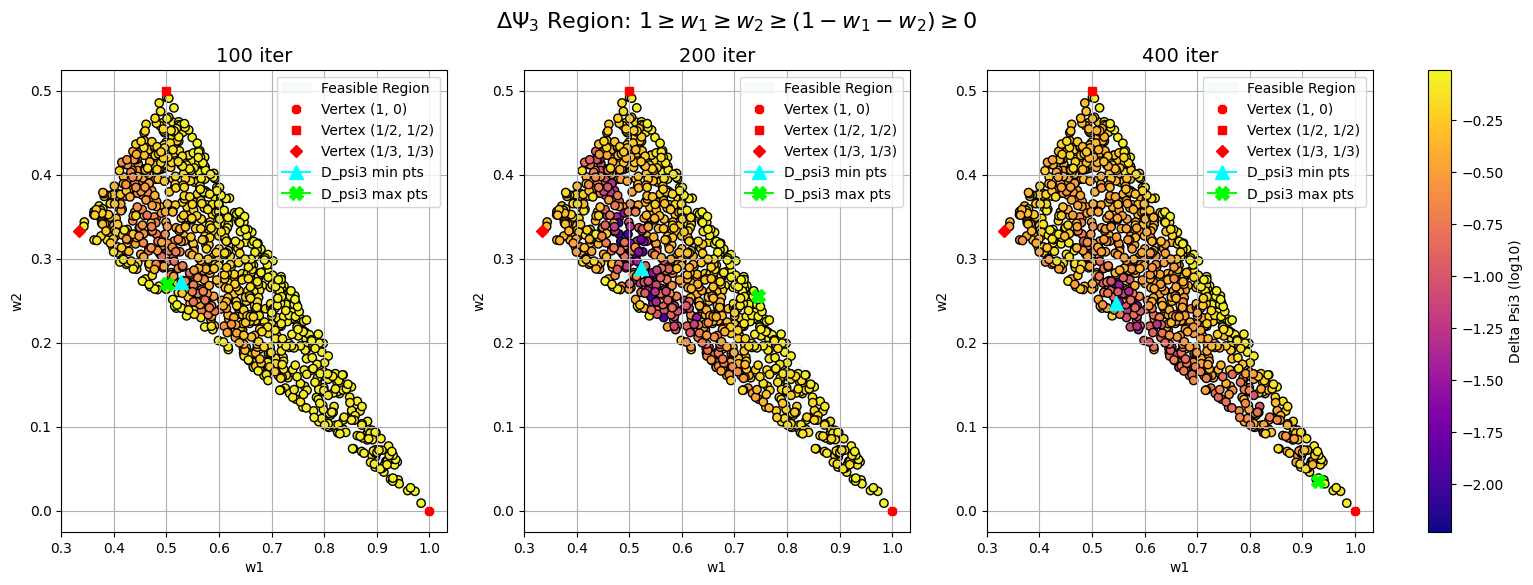

In [52]:
all_delta_Epsi3 = np.concatenate([logdelta_psi3100,logdelta_psi3200,logdelta_psi3400])
norm = mcolors.Normalize(vmin=np.min(all_delta_Epsi3), vmax=np.max(all_delta_Epsi3))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta \Psi_3$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_psi3, subtitle in zip(axes, [logdelta_psi3100,logdelta_psi3200,logdelta_psi3400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    #ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_psi3)][0]
    wminy = w_list[np.argmin(delta_psi3)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_psi3 min pts')

    wmaxx = w_list[np.argmax(delta_psi3)][0]
    wmaxy = w_list[np.argmax(delta_psi3)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_psi3 max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_psi3, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Psi3 (log10)')

plt.show()

### All

In [54]:
delta_psiall_100=np.array(delta_psi1_100)+np.array(delta_psi2_100)+np.array(delta_psi3_100)
delta_psiall_200=np.array(delta_psi1_200)+np.array(delta_psi2_200)+np.array(delta_psi3_200)
delta_psiall_400=np.array(delta_psi1_400)+np.array(delta_psi2_400)+np.array(delta_psi3_400)

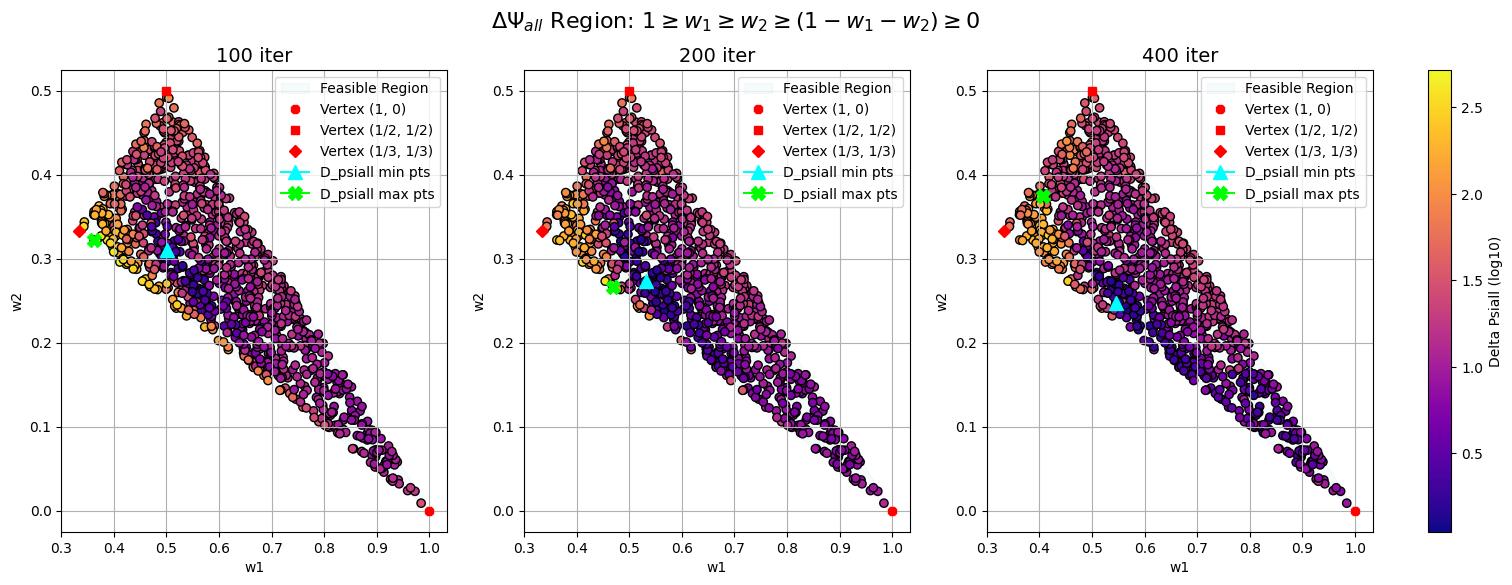

In [59]:
all_delta_psiall = np.concatenate([delta_psiall_100,delta_psiall_200,delta_psiall_400])
norm = mcolors.Normalize(vmin=np.min(all_delta_psiall), vmax=np.max(all_delta_psiall))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add main title
fig.suptitle(r'$\Delta \Psi_{all}$ Region: $1 \geq w_1 \geq w_2 \geq (1-w_1-w_2) \geq 0$', fontsize=16)

# Subtitles for each subplot
subtitles = ['100 iter', '200 iter', '400 iter']

for ax, delta_psiall, subtitle in zip(axes, [delta_psiall_100,delta_psiall_200,delta_psiall_400], subtitles):
    cmap = cm.plasma

    # Plot the feasible region
    ax.fill_between(x_vals, y_vals_lower, y_vals_upper, where=(y_vals_upper >= y_vals_lower), color='lightblue', alpha=0.1, label="Feasible Region")

    # Mark the vertices
    ax.plot(v1_x, v1_y, 'r8', markersize=6, label='Vertex (1, 0)')
    ax.plot(v2_x, v2_y, 'rs', markersize=6, label='Vertex (1/2, 1/2)')
    ax.plot(v3_x, v3_y, 'rD', markersize=6, label='Vertex (1/3, 1/3)')
    #ax.plot(vox, voy, 'r*', markersize=10, label='optimal points (Lexin\'s Thm7)')

    wminx = w_list[np.argmin(delta_psiall)][0]
    wminy = w_list[np.argmin(delta_psiall)][1]
    ax.plot(wminx, wminy, color='cyan', marker='^', markersize=10, label='D_psiall min pts')

    wmaxx = w_list[np.argmax(delta_psiall)][0]
    wmaxy = w_list[np.argmax(delta_psiall)][1]
    ax.plot(wmaxx, wmaxy, color='lime', marker='X', markersize=10, label='D_psiall max pts')

    # Scatter plot of positions with color mapping
    sc = ax.scatter(positions[:, 0], positions[:, 1], alpha=1, c=delta_psiall, cmap=cmap, edgecolors='black', norm=norm)

    # Set plot properties
    ax.set_xlabel('w1')
    ax.set_ylabel('w2')
    ax.set_title(subtitle, fontsize=14)

    ax.legend()
    ax.grid(True)

# Create a single colorbar for all subplots
cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Delta Psiall (log10)')

plt.show()